# Crossmatch to optical positions of ECDF X-ray sources

## Import modules

In [1]:
from lsst.rsp import get_tap_service, retrieve_query

from astropy.table import Table
from astropy.io import fits

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 50)

## Start the TAP service

In [2]:
service = get_tap_service("tap")
assert service is not None

## List the available tables in DP1

In [104]:
query = """
    SELECT * 
    FROM tap_schema.tables
    WHERE schema_name = 'dp02_dc2_catalogs'
    
    """
results = service.search(query).to_table()
results

schema_name,table_name,table_type,utype,description,table_index
str512,str64,str8,str512,str512,int32
dp02_dc2_catalogs,dp02_dc2_catalogs.CcdVisit,table,,Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,80
dp02_dc2_catalogs,dp02_dc2_catalogs.CoaddPatches,table,,Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,90
dp02_dc2_catalogs,dp02_dc2_catalogs.DiaObject,table,,Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,40
dp02_dc2_catalogs,dp02_dc2_catalogs.DiaSource,table,,Properties of transient-object detections on the single-epoch difference images.,50
dp02_dc2_catalogs,dp02_dc2_catalogs.ForcedSource,table,,"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",30
dp02_dc2_catalogs,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,,"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",60
dp02_dc2_catalogs,dp02_dc2_catalogs.MatchesTruth,table,,Match information for TruthSummary objects.,110
dp02_dc2_catalogs,dp02_dc2_catalogs.Object,table,,Properties of the astronomical objects detected and measured on the deep coadded images.,10
dp02_dc2_catalogs,dp02_dc2_catalogs.ObsCore,table,,Observation metadata in the ObsTAP relational realization of the IVOA ObsCore data model,65


## List the columns in a specific table

In [8]:
query = """
    SELECT column_name, datatype, description, unit
    FROM tap_schema.columns
    WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'
"""
results = service.search(query).to_table().to_pandas()
results

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure whe...,
1,ccdVisitId,long,Primary key (unique identifier).,
2,darkTime,double,"Average dark current accumulation time, accura...",s
3,decl,double,Declination of CCD center.,deg
4,detector,long,Detector ID. A detector associated with a part...,
5,expMidpt,char,"Midpoint for exposure. TAI, accurate to 10ms.",
6,expMidptMJD,double,"Midpoint for exposure in MJD. TAI, accurate to...",d
7,expTime,double,"Spatially-averaged duration of exposure, accur...",s
8,llcdec,double,Declination of lower left corner.,deg
9,llcra,double,RA of lower left corner.,deg


## Read in the Xue+2016 ECDF catalog

In [18]:
hdul = fits.open('../DATA/ECDFS.fits')
data = hdul[1].data
table = Table(data)
xpos = table[['Seq', 'RAJ2000','DEJ2000']]

## Write the query to positionally match to the ECDF catalog

In [99]:
match_radius_in_arcsec = 10.
query = f"""
SELECT obj.objectId as objectId,
xpos.seq AS xseq,
xpos.RAJ2000 as XRA, xpos.DEJ2000 as XDec, 
obj.coord_ra as RA, obj.coord_dec as Dec, 
obj.g_psfMag as gmag, obj.r_psfMag as rmag, obj.i_psfMag as imag,
DISTANCE(
    POINT('ICRS', obj.coord_ra, obj.coord_dec),
    POINT('ICRS', xpos.RAJ2000, xpos.DEJ2000)
) as separation
FROM dp1.Object as obj, TAP_UPLOAD.xpos AS xpos
WHERE CONTAINS(
    POINT('ICRS', obj.coord_ra, obj.coord_dec),
    CIRCLE('ICRS', xpos.RAJ2000, xpos.DEJ2000, {match_radius_in_arcsec / 3600:.5f})
)=1
"""

## Run the query, providing the ECDF positions as an upload

In [100]:
job = service.submit_job(query, uploads={"xpos": xpos})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [36]:
matches = job.fetch_result()

## Extract the matches and plot their separations

There are 1064 matches to 1003 X-ray sources.


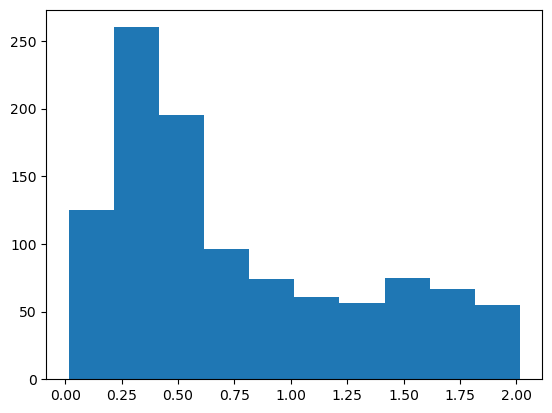

In [37]:
matches = job.fetch_result().to_table()
print(f'There are {len(matches)} matches to {len(xpos)} X-ray sources.')

plt.hist(matches['separation']*3600.)

plt.show()

## Match to the forcedSource table on objectId, and JOIN the visit table to get MJD data

In [48]:
idList = "(" + ", ".join(str(value) for value in matches['objectId']) + ")"
query = f"""
SELECT fs.objectId as objectId,
fs.psfDiffFlux as psfDiffFlux,
fs.psfDiffFluxErr as psfDiffFluxErr,
fs.psfDiffFlux_flag as psfDiffFlux_flag,
v.expMidptMJD as mjd, v.band as band
FROM dp1.ForcedSource as fs
JOIN dp1.Visit as v ON v.visit = fs.visit
WHERE fs.objectId IN {idList}  
"""

In [5]:
job = service.submit_job(query)#, uploads={"matches": matches})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [50]:
forcedPhot = job.fetch_result()

## Merge matched and forced photometry tables to combine X-ray and LSST data into one table

In [70]:
joined = pd.merge(matches.to_pandas(), forcedPhot.to_table().to_pandas(), on='objectId', how='right')

## Plot the (g, r, i) lightcurves of the seq=500 X-ray source

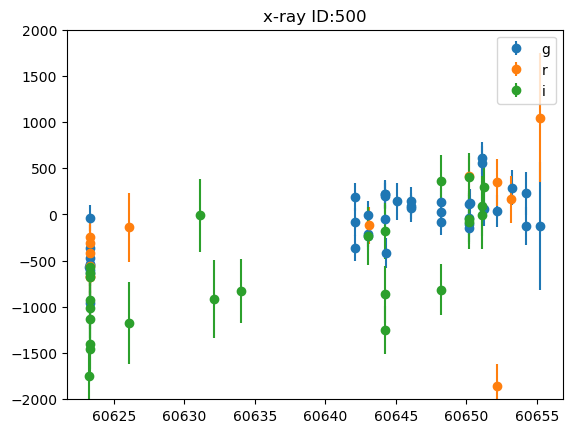

In [98]:
xseq = 500
for band in ['g','r','i']:
    subtable = joined[(joined['xseq'] == xseq) & (joined['band'] == band)]
    plt.errorbar(subtable['mjd'],
                 subtable['psfDiffFlux'],
                 yerr=subtable['psfDiffFluxErr'],
                 linestyle='none', fmt='o', label=band)
plt.ylim(-2000,2000)
plt.title(f"x-ray ID:{subtable['xseq'].iloc[0]}")
plt.legend()
plt.show()